# [I]()nteractive [M]()ultimodal e[X]()planations for [E]()asy [V]()isual [Q]()uestion [A]()nswering ([IMX-EVQA]())

This notebook includes examples of the interactive explanations provided in our adaptation of the study of [Alipour et al. 2020](https://arxiv.org/abs/2003.00431). 

## Model deployment

The [easy-VQA dataset](https://github.com/vzhou842/easy-VQA/tree/master/easy_vqa/data) contains simple images for visual question answering. The number of possible answers is 13, but we removed the answers  `yes` and `no` for our experiments.

In [ ]:
# load the model
import cv2, torch 
from system import XVQASystem
from utils import EasyVQA
import matplotlib.pyplot as plt

# load the system stored at results/ in the 
system = XVQASystem.load('results/', 'cuda:0')

# load test data
test = EasyVQA.from_path('easy-vqa/test/images/', 'easy-vqa/test/questions.json')

print('Classes:')
print(system.answer_tkz.counter.keys())

Classes:
dict_keys(['rectangle', 'blue', 'triangle', 'red', 'brown', 'circle', 'yellow', 'black', 'gray', 'teal', 'green'])


Let's see the first test example. In the left figure we show the image with the question and the gold answer. In the right figure there is the ideal human-like attention mask. To answer the question "What is the red shape?", a human would focus on the red triangle of the image and answer "triangle".


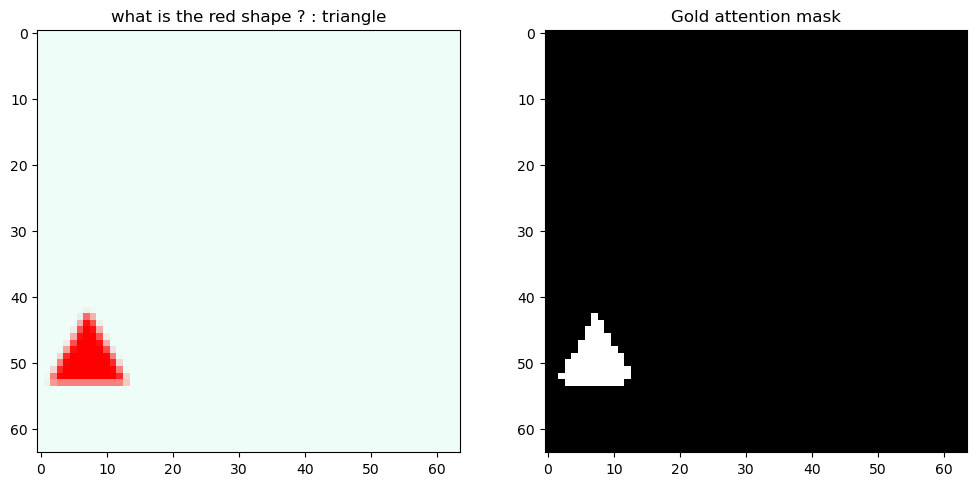

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 6))
instance = test[0]
ax[0].imshow(instance.IMG)
ax[0].set_title(f'{instance.QUESTION} : {instance.ANSWER}')
ax[1].imshow(instance.MASK, cmap='gray')
ax[1].set_title(f'Gold attention mask')
plt.show()

Let's see now the output of the model instead. The method `predict()` allows to introduce the dataset to the system and output the answers and masks:

predict: 100%|██████████| 26/26 [00:01<00:00, 14.72it/s]


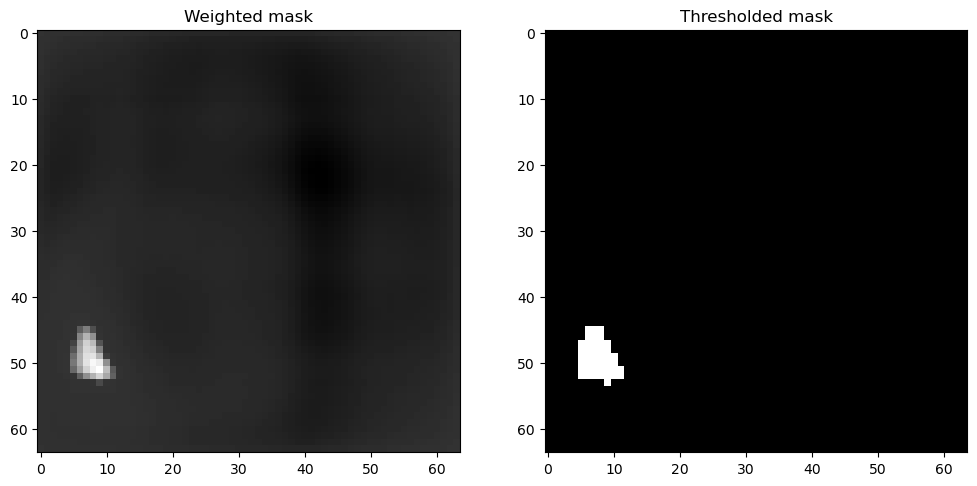

{'rectangle': -0.012607255019247532,
 'blue': -0.008351462893188,
 'triangle': 12.907938957214355,
 'red': -0.07431723922491074,
 'brown': -0.0067248293198645115,
 'circle': 7.784041881561279,
 'yellow': -0.02975340373814106,
 'black': -0.2595726251602173,
 'gray': -0.03252222016453743,
 'teal': -0.06240413710474968,
 'green': 1.8897603750228882}

In [ ]:
# predict all dataset
answers, masks = system.predict(test, batch_size=100)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 6))
ax[0].imshow(masks[0].cpu(), cmap='gray')
ax[0].set_title('Weighted mask')
ax[1].imshow(masks[0].cpu() > 0, cmap='gray')
ax[1].set_title('Thresholded mask')
plt.show()
answers[0]

See the scores assigned correctly predict "traingle" and the model activates those pixels near the triangular shape in the image. It is understandable that the model has payed attention to those pixels to correctly predict the answer. Let's get now an example where the model has failed:

In [ ]:
import numpy as np
gold = np.array([instance.ANSWER for instance in test])
pred = np.array([sorted(answer.keys(), key=answer.get)[-1] for answer in answers])
# instances where the model missclassifies
(gold != pred).nonzero()


(array([   2,   17,   18,   19,   20,   83,  155,  241,  243,  257,  258,
         266,  277,  280,  281,  282,  359,  422,  481,  565,  682,  689,
         690,  760,  786,  879,  943, 1017, 1018, 1069, 1106, 1108, 1180,
        1290, 1291, 1323, 1353, 1375, 1398, 1555, 1571, 1586, 1594, 1595,
        1789, 1937, 1939, 1951, 1992, 2123, 2124, 2167, 2178, 2189, 2190,
        2191, 2200, 2255, 2271, 2272, 2286, 2287, 2358, 2392]),)

Let's get now some of the instances where the model fails and see its scores and mask. 

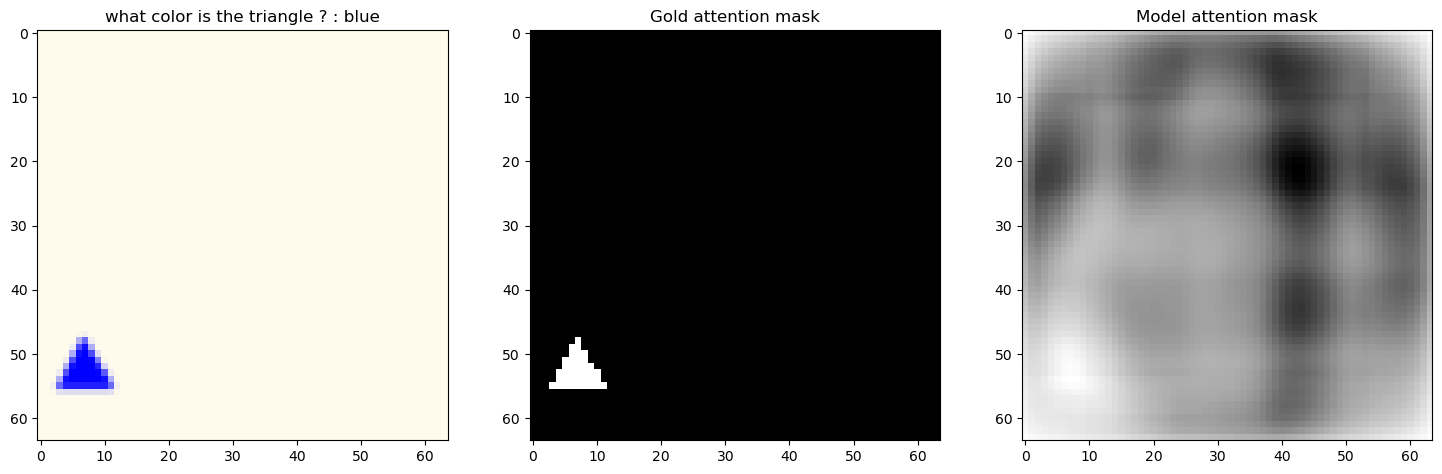

{'rectangle': -0.026581764221191406,
 'blue': 2.880643129348755,
 'triangle': -0.010088986717164516,
 'red': 4.136358261108398,
 'brown': 2.4082281589508057,
 'circle': -0.024950210005044937,
 'yellow': 2.89424729347229,
 'black': 4.1750264167785645,
 'gray': 4.639469146728516,
 'teal': 5.708524703979492,
 'green': 1.533090353012085}

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6*3, 6))
instance = test[282]
answer, mask = answers[282], masks[282].cpu()
ax[0].imshow(instance.IMG)
ax[0].set_title(f'{instance.QUESTION} : {instance.ANSWER}')
ax[1].imshow(instance.MASK, cmap='gray')
ax[1].set_title(f'Gold attention mask')
ax[2].imshow(mask, cmap='gray')
ax[2].set_title('Model attention mask')
plt.show()
answer

We see that the model is predicting the answer "teal" where the correct answer would be "blue". Let's now simulate a user manual mask to correct its answer (the user mask could be more flexible, with a more irregular form, but for simplicity we will create a rectangular mask):

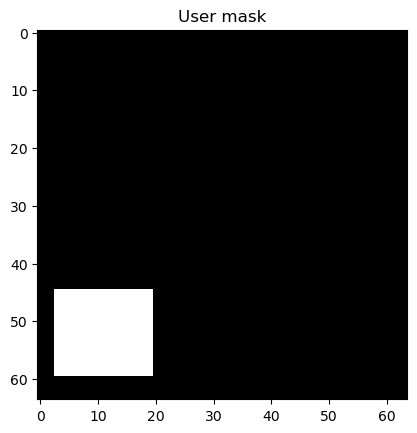

In [ ]:
user = torch.zeros_like(mask).to(torch.bool)
user[45:60, 3:20] = True
plt.imshow(user, cmap='gray')
plt.title('User mask')
plt.show()

In [ ]:
# override masks
masks[282] = user.to(system.device)
new_answers = system.feedback(test, masks, 100)
new_answers[282]

feedback: 100%|██████████| 26/26 [00:01<00:00, 22.27it/s]


{'rectangle': 0.5268875956535339,
 'blue': 2.877552032470703,
 'triangle': 0.5227873921394348,
 'red': 2.806880235671997,
 'brown': 5.786093711853027,
 'circle': -0.013631703332066536,
 'yellow': 3.2011539936065674,
 'black': -0.06480953842401505,
 'gray': 8.898821830749512,
 'teal': 3.162674903869629,
 'green': -0.019760917872190475}

See that now the scores have changed and the new predicted answer is "gray". This is also incorrect, but it allows the user to experiment and understand how the model is reacting to each attention mask to output an answer. We can test what happens if we introduce the gold mask:

In [ ]:
masks[282] = instance.MASK.to(system.device)
new_answers = system.feedback(test, masks, 100)
new_answers[282]

feedback: 100%|██████████| 26/26 [00:01<00:00, 22.29it/s]


{'rectangle': -0.01968824863433838,
 'blue': 6.1244988441467285,
 'triangle': -0.01154131069779396,
 'red': 3.6616592407226562,
 'brown': 1.0466121435165405,
 'circle': -0.021388260647654533,
 'yellow': 1.1042183637619019,
 'black': 0.7903327345848083,
 'gray': 4.122711181640625,
 'teal': 5.472358703613281,
 'green': 3.6209490299224854}

Nice! Now, we see that by introducing the gold mask, the model answer changes again and the prediction is correct ("blue"). 